In [1]:
import numpy as np
import gbd
import raytrace as rt
import utils as ut
from scipy.io import loadmat
import matplotlib.pyplot as plt
from IPython.display import Audio
sound_file = './sound/beep.wav'

def filter_offdiagonal_abcd(ABCD):
    
    # A Submatrix
    ABCD[0,1,:] = 0
    ABCD[1,0,:] = 0
    
    # B Submatrix
    ABCD[0,3,:] = 0
    ABCD[1,2,:] = 0
    
    # C Submatrix
    ABCD[2,1,:] = 0
    ABCD[3,0,:] = 0
    
    # D Submatrix
    ABCD[2,3,:] = 0
    ABCD[3,2,:] = 0
    
    return ABCD

def diagonalize_abcd(ABCD):
    
    from numpy.linalg import eig,inv
    
    abcd_box = np.zeros(ABCD.shape)
    
    for i in range(ABCD.shape[-1]):
        
        evals,evecs = eig(ABCD[:,:,i])
        abcd_box[:,:,i] = inv(evecs) @ ABCD[:,:,i] @ evecs
        
    return abcd_box

numexpr sees numcores =  8
numexpr sees numthreads =  8
numexpr sees max threads =  96
numba threads =  8


In [2]:
# set up optical system
wl = 2.2e-6
npix = 256
size = 2.4

# set up detector
dsize = 1.22*wl*(57.6/2.4)*25
x = np.linspace(-dsize/2,dsize/2,npix)
x,y = np.meshgrid(x,x)

# set up gaussian
wo = 9200*wl
zr = np.pi * wo**2 / wl # meters
q  = 1j*zr
qinv = 1/q
k = 2*np.pi/wl

# an orthogonal beamlet
Qinv = np.array([[qinv,0],
                 [0,qinv]])

print('wo = ',wo,' [m]')

wo =  0.02024  [m]


In [3]:
# create rayset
# 9200wl is to fit to the Zemax data set
rays = gbd.ComputeRaysFromOF(1.7,size,wo)

# Convert ABCD 
pth_to_gbd_data = '/Users/jashcraft/Desktop/gbd-data/'
# rtm_pth = 'Hubble_nominal.mat'
rtm_pth = 'Hubble_YDEC5E-4.mat'
pth = pth_to_gbd_data + rtm_pth
ABCD = loadmat(pth)['plotbox']
# ABCD = filter_offdiagonal_abcd(ABCD)
# ABCD = diagonalize_abcd(ABCD)

# Convert lo
lo_pth = 'Hubble_Onax_lo.mat'
pth = pth_to_gbd_data + lo_pth
lo = np.squeeze(loadmat(pth)['lo'])

# Artificial ABCD appears to work as expected!
# efl = 57.6
# dis = 57.6
# abcd = np.array([[1-dis/efl + 1e-20,0,dis,0],
#                  [0,1-dis/efl + 1e-20,0,dis],
#                  [-1/efl,0,1,0],
#                  [0,-1/efl,0,1]])

# abcd_box = np.zeros([4,4,rays.shape[1]])

# for ijk in range(rays.shape[1]):
    
#     abcd_box[:,:,ijk] = abcd
    
# ABCD = abcd_box

# Load rays out
# rayout_pth = 'rayout_onax.mat'
rayout_pth = 'rayout_YDEC5E-4.mat'
pth = pth_to_gbd_data + rayout_pth
zmxraysout = loadmat(pth)['rays']
zmx_x = zmxraysout[0,:]
zmx_y = zmxraysout[1,:]
zmx_u = zmxraysout[2,:]
zmx_v = zmxraysout[3,:]
zmx_raysout = np.array([zmx_x,zmx_y,zmx_u,zmx_v])

# Check against pupilcords
# ray_pth = 'rayin_onax.mat'
ray_pth = 'rayin_YDEC5E-4.mat'
pth = pth_to_gbd_data + ray_pth
zmxrays = loadmat(pth)['rays']
zmx_x = zmxrays[0,:]
zmx_y = zmxrays[1,:]
zmx_rays = np.array([zmx_x,zmx_y,zmx_x*0,zmx_y*0])

# filter outside of circle - nonparaxial zemax data
ABCD = ABCD[:,:,np.sqrt(zmx_x**2 + zmx_y**2) <= (1.2)]
zmx_rays = zmx_rays[:,np.sqrt(zmx_x**2 + zmx_y**2) <= (1.2)]
zmx_raysout = zmx_raysout[:,np.sqrt(zmx_x**2 + zmx_y**2) <= (1.2)]
lo = lo[np.sqrt(zmx_x**2 + zmx_y**2) <= (1.2)]

rays = rays[:,np.sqrt(rays[0,:]**2 + rays[1,:]**2) <= (1.2)]

# ABCD = ABCD[:,:,np.sqrt(rays[0,:]**2 + rays[1,:]**2) <= (1.2-wo/2)]
# rays = rays[:,np.sqrt(rays[0,:]**2 + rays[1,:]**2) <= (1.2-wo/2)]

# Compute centroid
x_cen = np.mean(zmx_raysout[0,:])
y_cen = np.mean(zmx_raysout[1,:])
print('centroid = ',x_cen,y_cen)

centroid =  0.0 -0.0046564569049630045


In [4]:
%%time
field = gbd.EvalGausslets(x+x_cen,y+y_cen,zmx_rays,Qinv,k,ABCD,npix,raysout=zmx_raysout,lo=None)

Number of Gausslets =  7845
finished tracing  7844  Gausslets
CPU times: user 1h 29min 59s, sys: 5min 14s, total: 1h 35min 14s
Wall time: 14min 19s


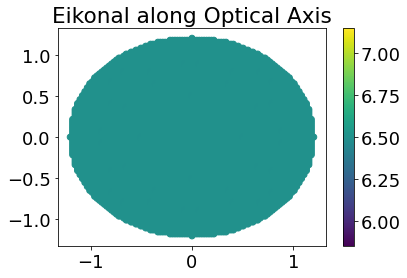

In [5]:
plt.figure()
plt.title('Eikonal along Optical Axis')
plt.scatter(zmx_rays[0,:],zmx_rays[1,:],c=lo)
plt.colorbar()

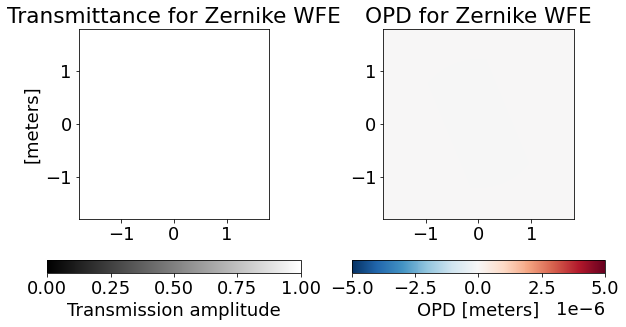

In [7]:
# Set up and propagate Fresnel
import poppy
import astropy.units as u
wlen = wl
wf = poppy.FresnelWavefront(size/2*u.m,wavelength=wlen,npix=npix,oversample=8)
circ = poppy.CircularAperture(radius=size/2*u.m)
#pwfe = poppy.ArrayOpticalElement(transmission=np.ones(phase.shape),opd=phase,pixelscale=wf.pixelscale)
amount = 2.2e-10
pwfe = poppy.ZernikeWFE(coefficients=[0,0,0,amount,
                                            amount,
                                            amount],radius=size/2*u.m)
thin = poppy.QuadraticLens(10*size*u.m)

# Grab applied WFE
opd_to_pass = ut.grab_center(pwfe.get_opd(wf),npix/2)

plt.figure(figsize=[10,5])
pwfe.display(what='both',opd_vmax=50e-7)
plt.show()

<Figure size 432x288 with 0 Axes>

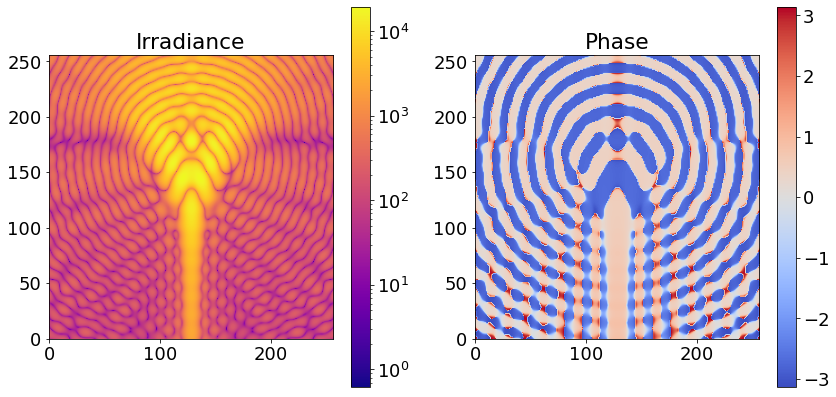

In [8]:
irrad = np.abs(field*np.conj(field))
phase = np.angle(field)

ut.amp_phase_plot(field,logintensity=True)

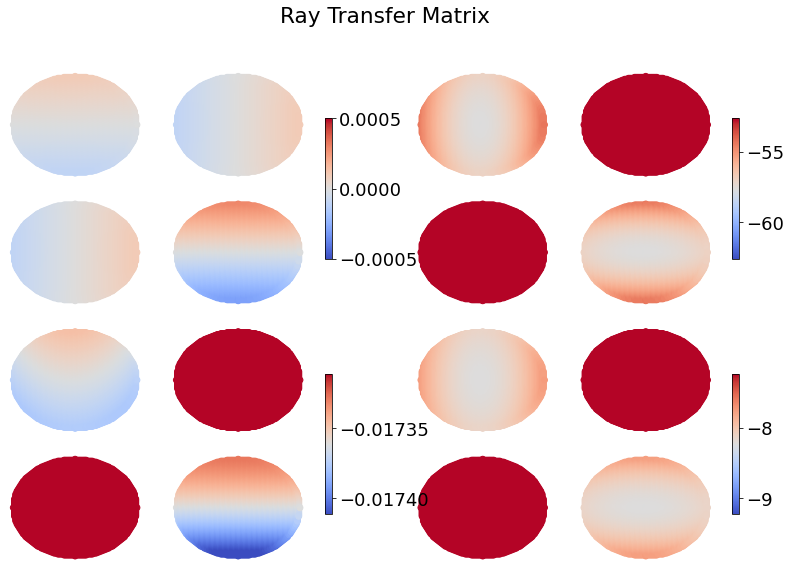

array([[[-3.83342422e-07],
        [ 0.00000000e+00],
        [-5.75998634e+01],
        [-0.00000000e+00]],

       [[ 4.28561553e-08],
        [-3.25452130e-07],
        [ 1.21898272e-06],
        [-5.75998715e+01]],

       [[-1.73612071e-02],
        [ 0.00000000e+00],
        [-8.22543489e+00],
        [-0.00000000e+00]],

       [[ 7.32414531e-09],
        [-1.73612083e-02],
        [-2.62268682e-07],
        [-8.22543824e+00]]])

In [9]:
import importlib
importlib.reload(ut)
ut.fourbyfour(ABCD,zmx_rays[0,:],zmx_rays[1,:],size=1)

ABCD[:,:,zmx_rays[0,:]**2 + zmx_rays[1,:]**2 == 0]

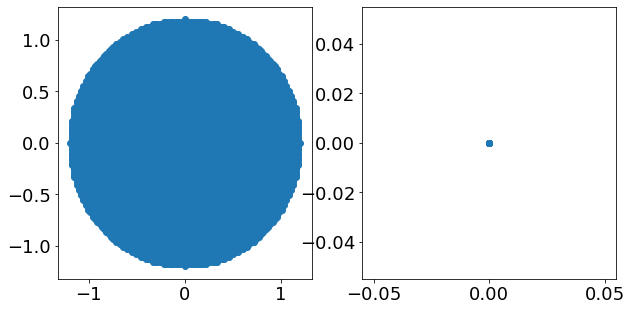

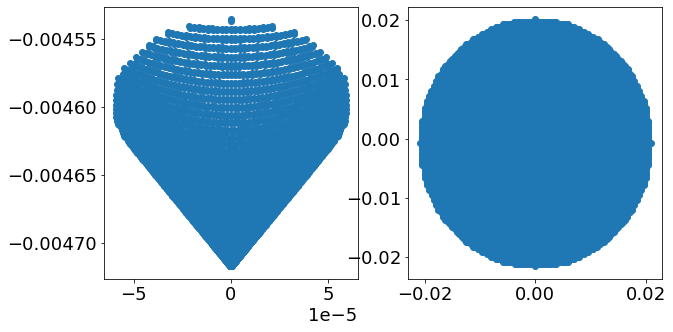

In [10]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(zmx_rays[0,:],zmx_rays[1,:])
plt.subplot(122)
plt.scatter(zmx_rays[2,:],zmx_rays[3,:])
plt.show()

zmx_prop = rt.matmultrays(ABCD,zmx_rays)

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(zmx_raysout[0,:],zmx_raysout[1,:])
plt.subplot(122)
plt.scatter(zmx_raysout[2,:],zmx_raysout[3,:])
plt.show()

In [11]:
# Compare against Zemax Huygens PSF
pth = pth_to_gbd_data + 'Hubble_YDEC5E-4_huygenspsf.txt'
huygenspsf = np.loadtxt(pth,delimiter='\t',encoding='UTF-16',skiprows=21)
huygens = huygenspsf/np.sum(huygenspsf)

<Figure size 432x288 with 0 Axes>

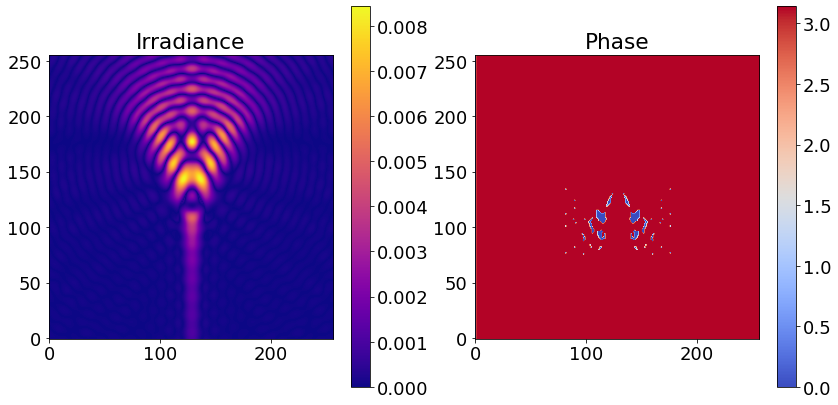

In [12]:
field_psf = field/np.sum(field)
from scipy.ndimage import shift
field_psf_shifted = shift(field_psf,[-0.5,0.5])
ut.amp_phase_plot(huygens-np.abs(field_psf_shifted),logintensity=False)

In [ ]:

wo = 2.4*1.7/202

In [ ]:
wo

In [ ]:
wop = 2.4*1.7/202
wo = 9200*wl
print(wop)
print(wo)

In [ ]:
Q = np.array([[1,2],
              [3,4]])

A = np.array([[5,6],
              [7,8]])

B = np.array([[9,10],
              [11,12]])

np.linalg.inv(A)

In [ ]:
-4*9 + 3*11 + 1

In [ ]:
-4*10+3*12 + 2

In [ ]:
-3.5*9 - 2.5*11 + 3

In [ ]:
-3.5*10-2.5*12 + 4

In [ ]:
Q + np.linalg.inv(A) @ B

In [ ]:
def Inv(M):
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]

    return 1/(a*d - b*c)*np.array([[d,-b],
                                   [-c,a]])

def Det(M):
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]

    return (a*d-b*c)

def Mult(M1,M2):

    a1 = M1[0,0]
    b1 = M1[0,1]
    c1 = M1[1,0]
    d1 = M1[1,1]

    a2 = M2[0,0]
    b2 = M2[0,1]
    c2 = M2[1,0]
    d2 = M2[1,1]

    A = a1*a2 + b1*c2
    B = a1*b2 + b1*d2
    C = c1*a2 + d1*c2
    D = c1*b2 + d1*d2

    mat = np.array([[A,B],[C,D]])

    return mat

In [ ]:
Q + Mult(Inv(A),B)